In [ ]:
!pip install pytorch-toolbelt --quiet
!pip install torchinfo --quiet
!pip install einops --quiet
!pip install medpy torchmetrics --quiet
!pip install thop --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 170.1/170.1 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 75.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 50.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 42.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 89.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.3/156.3 kB 5.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# dataset: https://www.kaggle.com/datasets/c7934597/cardiac-catheterization

%mkdir dataset
!unzip -o 'drive/MyDrive/cardiac-catheterization.zip' -d 'dataset'

Archive:  drive/MyDrive/cardiac-catheterization.zip
  inflating: dataset/Cardiac_Catheterization/train/images/0655[0]_47.png  
  inflating: dataset/Cardiac_Catheterization/train/images/0655[0]_48.png  
  inflating: dataset/Cardiac_Catheterization/train/images/0655[0]_49.png  
  inflating: dataset/Cardiac_Catheterization/train/images/0655[0]_50.png  
  inflating: dataset/Cardiac_Catheterization/train/images/0655[0]_51.png  
  inflating: dataset/Cardiac_Catheterization/train/images/0655[0]_52.png  
  inflating: dataset/Cardiac_Catheterization/train/images/0655[0]_53.png  
  inflating: dataset/Cardiac_Catheterization/train/images/0655[0]_54.png  
  inflating: dataset/Cardiac_Catheterization/train/images/0655[0]_55.png  
  inflating: dataset/Cardiac_Catheterization/train/images/0655[0]_56.png  
  inflating: dataset/Cardiac_Catheterization/train/images/0655[0]_57.png  
  inflating: dataset/Cardiac_Catheterization/train/images/0655[0]_58.png  
  inflating: dataset/Cardiac_Catheterization/tra

In [ ]:

from sklearn.metrics import confusion_matrix, f1_score
from torchmetrics.functional import jaccard_index as torch_jaccard_index
from medpy.metric.binary import hd95
import torchinfo

import os
import random
from matplotlib import pyplot as plt

import numpy as np
import cv2

from torch import nn
import torch
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

from pytorch_toolbelt.losses.lovasz import BinaryLovaszLoss

from sklearn.model_selection import train_test_split

cudnn.benchmark = True
cuda = torch.cuda.is_available()

/usr/local/lib/python3.11/dist-packages/pytorch_toolbelt/losses/functional.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @torch.cuda.amp.autocast(False)
/usr/local/lib/python3.11/dist-packages/pytorch_toolbelt/losses/quality_focal_loss.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @torch.cuda.amp.autocast(False)


#Loading Data

In [ ]:
images_directory = 'dataset/Cardiac_Catheterization/train/images/'
masks_directory = 'dataset/Cardiac_Catheterization/train/masks/'

images_files = os.listdir(images_directory)
masks_files = os.listdir(masks_directory)

sample_image = cv2.imread(images_directory + images_files[0], flags=cv2.IMREAD_GRAYSCALE)

print('images count: ' + str(len(images_files)))
print('images shape: ' + str(sample_image.shape))

images count: 1717
images shape: (512, 512)


In [ ]:
image_size = 128
images = []
masks = []

for i, image_name in enumerate(images_files):
    image = cv2.imread(images_directory + image_name, flags=cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, (image_size, image_size))
    images.append(image)

for i, image_name in enumerate(masks_files):
    image = cv2.imread(masks_directory + image_name, flags=cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, (image_size, image_size))
    masks.append(image)

print('images shape: ' + str(images[0].shape))
print('masks shape: ' + str(masks[0].shape))

images shape: (128, 128)
masks shape: (128, 128)


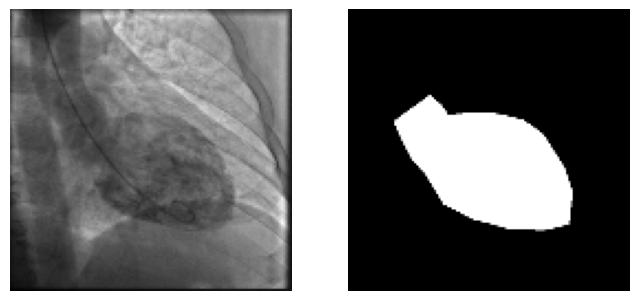

In [ ]:
idx = random.randint(0, len(images))

plt.figure(figsize=(8, 8))

plt.subplot(1, 2, 1)
plt.axis('off')
plt.imshow(images[idx], cmap='gray')

plt.subplot(1, 2, 2)
plt.axis('off')
plt.imshow(masks[idx], cmap='gray')
plt.show()

In [ ]:
batch_size = 16

class Dataset(torch.utils.data.Dataset):
    def __init__(self, images, masks):
        self.images = images
        self.masks = masks

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        mask = self.masks[idx]

        image = image.astype(np.float32)
        mask = mask.astype(np.float32)

        image = torch.from_numpy(image / 255.0).unsqueeze(0)
        mask = torch.from_numpy(mask / 255.0).unsqueeze(0)

        return image, mask


x_train, x_test, y_train, y_test = train_test_split(images, masks, test_size=0.2, random_state=0)

train_dataset = Dataset(x_train, y_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

test_dataset = Dataset(x_test, y_test)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

len(train_loader) * batch_size, len(test_loader) * batch_size

(1360, 336)

#Model

In [ ]:
# accuracy metric

def accuracy(y_true, y_pred):
    y_pred = (y_pred > 0.5).float()

    y_true = y_true.flatten()
    y_pred = y_pred.flatten()

    correct = (y_true == y_pred).sum()

    accuracy = correct / float(y_true.numel())

    return accuracy


def jaccard_index(y_true, y_pred):
    y_pred = (y_pred > 0.5).float()

    y_true = y_true.flatten()
    y_pred = y_pred.flatten()

    intersection = (y_true * y_pred).sum()
    union = torch.logical_or(y_true, y_pred).sum()

    jaccard = torch.where(union != 0.0, intersection / union, torch.tensor(0.0))

    return jaccard


def dice_coefficient(y_true, y_pred):
    y_pred = (y_pred > 0.5).float()

    y_true = y_true.flatten()
    y_pred = y_pred.flatten()

    intersection = (y_true * y_pred).sum()
    union = y_true.sum() + y_pred.sum()

    dice = torch.where(union != 0.0, (2 * intersection) / union, torch.tensor(0.0))

    return dice


def sensitivity(y_true, y_pred):
    y_pred = (y_pred > 0.5).float()
    y_true = y_true.flatten()
    y_pred = y_pred.flatten()
    tp = (y_true * y_pred).sum()
    fn = (y_true * (1 - y_pred)).sum()
    return tp / (tp + fn + 1e-8)

def specificity(y_true, y_pred):
    y_pred = (y_pred > 0.5).float()
    y_true = y_true.flatten()
    y_pred = y_pred.flatten()
    tn = ((1 - y_true) * (1 - y_pred)).sum()
    fp = ((1 - y_true) * y_pred).sum()
    return tn / (tn + fp + 1e-8)

def f1_score_metric(y_true, y_pred):
    y_pred = (y_pred > 0.5).float()
    y_true = y_true.int().flatten().cpu().numpy()
    y_pred = y_pred.int().flatten().cpu().numpy()
    return torch.tensor(f1_score(y_true, y_pred))

def hausdorff_distance(y_true, y_pred):
    y_pred = (y_pred > 0.5).float()
    y_true = y_true.squeeze().cpu().numpy().astype(bool)
    y_pred = y_pred.squeeze().cpu().numpy().astype(bool)
    try:
        return torch.tensor(hd95(y_true, y_pred))
    except:
        return torch.tensor(0.0)

def miou_metric(y_true, y_pred):
    y_pred = (y_pred > 0.5).int()
    return torch_jaccard_index(y_pred, y_true.int(), num_classes=2, task='binary')

In [ ]:
class OneConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(OneConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=(1, 1)),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)


class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=(3, 3), padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, kernel_size=(3, 3), padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)


class Down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(Down, self).__init__()
        self.pool = nn.MaxPool2d(2)
        self.double_conv = DoubleConv(in_ch, out_ch)

    def forward(self, x):
        x = self.pool(x)
        x = self.double_conv(x)
        return x


class DownRes(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(DownRes, self).__init__()
        self.pool = nn.MaxPool2d(2)
        self.mp_conv = DoubleConv(in_ch, out_ch)
        self.bridge = OneConv(in_ch, out_ch)

    def forward(self, x):
        x = self.pool(x)
        x_1 = self.mp_conv(x)
        x_2 = self.bridge(x)
        x = x_1 + x_2
        return x


class Up(nn.Module):
    def __init__(self, in_ch, out_ch, bilinear=True):
        super(Up, self).__init__()

        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_ch // 2, in_ch // 2, 2, stride=2)

        self.conv = DoubleConv(in_ch, out_ch)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        padding = [(x1.size()[2] - x2.size()[2]) // 2, (x1.size()[2] - x2.size()[2] + 1) // 2,
                   (x1.size()[3] - x2.size()[3]) // 2, (x1.size()[3] - x2.size()[3] + 1) // 2]
        x2 = nn.functional.pad(x2, padding)
        x = torch.cat([x2, x1], dim=1)
        x = self.conv(x)
        return x


class UpRes(nn.Module):
    def __init__(self, in_ch, out_ch, bilinear=True):
        super(UpRes, self).__init__()

        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_ch // 2, in_ch // 2, kernel_size=(2, 2), stride=(2, 2))

        self.conv = DoubleConv(in_ch, out_ch)
        self.bridge = OneConv(in_ch, out_ch)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        padding = [(x1.size()[2] - x2.size()[2]) // 2, (x1.size()[2] - x2.size()[2] + 1) // 2,
                   (x1.size()[3] - x2.size()[3]) // 2, (x1.size()[3] - x2.size()[3] + 1) // 2]
        x2 = nn.functional.pad(x2, padding)
        x = torch.cat([x2, x1], dim=1)
        x = self.conv(x) + self.bridge(x)
        return x


class Model(nn.Module):
    def __init__(self, model_type, n_channels=1, n_classes=1):
        super(Model, self).__init__()
        f = 4

        self.in_conv = DoubleConv(n_channels, f)

        if model_type == 'UNet':
            self.down1 = Down(f, f * 2)
            self.down2 = Down(f * 2, f * 4)
            self.down3 = Down(f * 4, f * 8)
            self.down4 = Down(f * 8, f * 8)

            self.up1 = Up(f * 16, f * 4)
            self.up2 = Up(f * 8, f * 2)
            self.up3 = Up(f * 4, f)
            self.up4 = Up(f * 2, f)

        elif model_type == 'ResNet':
            self.down1 = DownRes(f, f * 2)
            self.down2 = DownRes(f * 2, f * 4)
            self.down3 = DownRes(f * 4, f * 8)
            self.down4 = DownRes(f * 8, f * 8)

            self.up1 = UpRes(f * 16, f * 4)
            self.up2 = UpRes(f * 8, f * 2)
            self.up3 = UpRes(f * 4, f)
            self.up4 = UpRes(f * 2, f)

        self.out = OneConv(f, n_classes)

        if n_classes == 1:
            self.out_activation = F.sigmoid
        elif n_classes > 1:
            self.out_activation = F.softmax

    def forward(self, x):
        x1 = self.in_conv(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        x = self.out(x)
        return self.out_activation(x)

In [ ]:

class ModelFit:
    def __init__(self, model, criterion=None, optimizer=None, metrics=None):
        self.model = model
        self.criterion = criterion if criterion is not None else nn.BCELoss()
        self.optimizer = optimizer if optimizer is not None else torch.optim.Adam(self.model.parameters(), lr=0.001)
        self.metrics = metrics if metrics is not None else [
            accuracy,
            dice_coefficient,
            jaccard_index,
            sensitivity,
            specificity,
            f1_score_metric,
            hausdorff_distance,
            miou_metric,
        ]
        self.metrics_names = [f.__name__ for f in self.metrics]

        self.train_loader = None
        self.test_loader = None

        self.cuda = torch.cuda.is_available()
        if self.cuda:
            self.model.cuda()
            self.criterion.cuda()

    def _train_batch(self, inputs, targets):
        if self.cuda:
            inputs = inputs.cuda()
            targets = targets.cuda()

        self.optimizer.zero_grad()
        outputs = self.model(inputs)
        loss = self.criterion(outputs, targets)
        loss.backward()
        self.optimizer.step()
        metrics = [metric(targets, outputs).item() for metric in self.metrics]

        return loss.item(), metrics

    def _test_batch(self, inputs, targets):
        if self.cuda:
            inputs = inputs.cuda()
            targets = targets.cuda()

        outputs = self.model(inputs)
        loss = self.criterion(outputs, targets)
        metrics = [metric(targets, outputs).item() for metric in self.metrics]

        return loss.item(), metrics

    def _train_epoch(self, epoch, epochs):
        self.model.train()

        epoch_loss = 0
        epoch_metrics = np.zeros((len(self.metrics)))
        batches_n = len(self.train_loader)
        i = 0

        for inputs, targets in self.train_loader:
            i += 1

            loss, metrics = self._train_batch(inputs, targets)

            epoch_loss += loss
            epoch_metrics += np.array(metrics)

            info = f"\rEpoch: {f'{epoch}/{epochs}':<7} Batch: {f'{i}/{batches_n}':<7} [ loss: {epoch_loss / i:.4f}"
            for n in range(len(self.metrics)):
                info += f" - {self.metrics_names[n]}: {epoch_metrics[n] / i:.4f}"
            info += " ]"

            print(info, end='')

        epoch_loss /= batches_n
        epoch_metrics /= batches_n
        return epoch_loss, epoch_metrics

    def _test_epoch(self):
        self.model.eval()

        epoch_loss = 0
        epoch_metrics = np.zeros((len(self.metrics)))
        batches_n = len(self.test_loader)

        for inputs, targets in self.test_loader:
            loss, metrics = self._test_batch(inputs, targets)

            epoch_loss += loss
            epoch_metrics += np.array(metrics)

        epoch_loss /= batches_n
        epoch_metrics /= batches_n

        info = f" [ val_loss: {epoch_loss:.4f}"
        for n in range(len(self.metrics)):
            info += f" - val_{self.metrics_names[n]}: {epoch_metrics[n]:.4f}"
        info += " ]"

        print(info)

        return epoch_loss, epoch_metrics

    def fit(self, train_loader, epochs, test_loader=None):
        self.train_loader = train_loader
        self.test_loader = test_loader

        train_loss_history = []
        train_metrics_history = []
        test_loss_history = []
        test_metrics_history = []

        for epoch in range(epochs):
            loss, train_metrics = self._train_epoch(epoch + 1, epochs)
            train_loss_history.append(loss)
            train_metrics_history.append(train_metrics)

            if self.test_loader is not None:
                test_loss, test_metrics = self._test_epoch()
                test_loss_history.append(test_loss)
                test_metrics_history.append(test_metrics)

        result = {}
        result['train_loss'] = train_loss_history
        result['val_loss'] = test_loss_history

        for i, metric in enumerate(zip(*train_metrics_history)):
            result['train_' + self.metrics_names[i]] = metric

        for i, metric in enumerate(zip(*test_metrics_history)):
            result['val_' + self.metrics_names[i]] = metric

        print('\n')
        return result

    def evaluate(self):
        pass

In [ ]:
# plotting

def plot_metric(history, metric):
    plt.figure(figsize=(10, 4))

    epochs = range(1, len(history['train_' + metric]) + 1)

    plt.plot(epochs, history['train_' + metric], label='train ' + metric)
    plt.plot(epochs, history['val_' + metric], label='test ' + metric)

    plt.xlabel('epoch')
    plt.ylabel(metric)

    plt.legend()
    plt.grid(True)

    plt.show()


def evaluate(model, data_loader, metric=dice_coefficient):
    model.eval()

    if cuda:
        model.cuda()

    s = 0
    batches_n = len(data_loader)

    for inputs, targets in data_loader:
        if cuda:
            inputs = inputs.cuda()
            targets = targets.cuda()

        outputs = model(inputs)
        s += metric(targets, outputs)

    result = (s / batches_n)
    if torch.is_tensor(result):
        result = result.item()
    return result


def tensor_to_numpy_image(img):
    img = img.cpu()
    img = img.data.numpy().astype(np.float32)
    return img.T


def check(model, idx=None):
    model.eval()

    if idx is None:
        idx = random.randint(0, len(test_dataset))

    x, y = test_dataset[idx]

    inputs = x.unsqueeze(0)
    if cuda:
        inputs = inputs.cuda()

    y_pred = model(inputs)[0]
    y_pred = tensor_to_numpy_image(y_pred)

    prediction = (y_pred > 0.5)
    x = tensor_to_numpy_image(x)
    y = tensor_to_numpy_image(y)

    plt.figure(figsize=(8, 8))

    plt.subplot(2, 3, 1)
    plt.title('Image')
    plt.axis('off')
    plt.imshow(x, cmap='gray')

    plt.subplot(2, 3, 2)
    plt.title('Real Mask')
    plt.axis('off')
    plt.imshow(y, cmap='gray')

    plt.subplot(2, 3, 3)
    plt.title('Predicted Mask')
    plt.axis('off')
    plt.imshow(prediction, cmap='gray')

    plt.show()

#Loss Functions

In [ ]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.5, gamma=2.0):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.bce_loss = nn.BCELoss()

    def forward(self, inputs, targets):
        bce_loss = self.bce_loss(inputs, targets)
        pt = torch.exp(-bce_loss)
        focal_loss = (self.alpha * pt) * torch.pow(1.0 - pt, self.gamma)
        loss = focal_loss.mean()
        return loss


class DiceLoss(nn.Module):
    def __init__(self):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets):
        intersection = (inputs * targets).sum()
        loss = 1 - (2 * intersection) / (inputs.sum() + targets.sum() + 1e-5)
        return loss


class DiceBCELoss(nn.Module):
    def __init__(self):
        super(DiceBCELoss, self).__init__()
        self.bce_loss = nn.BCELoss()
        self.dice_loss = DiceLoss()

    def forward(self, inputs, targets):
        dice_loss = self.dice_loss(inputs, targets)
        bce_loss = self.bce_loss(inputs, targets)
        loss = 0.5 * (dice_loss + bce_loss)
        return loss


class HybridLoss(nn.Module):
    def __init__(self):
        super(HybridLoss, self).__init__()
        self.bce_loss = nn.BCELoss()
        self.dice_loss = DiceLoss()

        self.sobel_x = nn.Conv2d(1, 1, kernel_size=3, padding=1, bias=False)
        self.sobel_y = nn.Conv2d(1, 1, kernel_size=3, padding=1, bias=False)

        self.sobel_x.weight.data.copy_(torch.tensor([[-1, 0, 1], [2, 0, -2], [-1, 0, 1]], dtype=torch.float32).view(1, 1, 3, 3))
        self.sobel_y.weight.data.copy_(torch.tensor([[1, 2, 1], [0, 0, 0], [-1, -2, -1]], dtype=torch.float32).view(1, 1, 3, 3))

    def compute_length(self, inputs):
        seg_channel = torch.argmax(inputs, dim=1, keepdim=True).float()

        edges_x = self.sobel_x(seg_channel)
        edges_y = self.sobel_y(seg_channel)
        edges = torch.square(edges_x) + torch.square(edges_y)
        length = torch.sum(edges, dim=[1, 2, 3])

        length = torch.mean(length + 1e-6)

        return length

    def forward(self, inputs, targets):
        bce_loss = self.bce_loss(inputs, targets)
        dice_loss = self.dice_loss(inputs, targets)
        length = self.compute_length(inputs)

        return bce_loss - 0.1 * dice_loss + length


class LovaszBCELoss(nn.Module):
    def __init__(self):
        super(LovaszBCELoss, self).__init__()
        self.bce_loss = nn.BCELoss()
        self.lovasz_loss = BinaryLovaszLoss()

    def forward(self, inputs, targets):
        loss = self.bce_loss(inputs, targets) + self.lovasz_loss(inputs, targets)
        return loss

#Checking model with different losses

In [ ]:
epochs = 20

models = []
base_models_names = []
base_accuracies = []

def check_loss(model_type, criterion):

    from torchinfo import summary
    from thop import profile

    model = Model(model_type)
    dummy_input = torch.randn(1, 1, image_size, image_size)

    if torch.cuda.is_available():
        model = model.cuda()
        dummy_input = dummy_input.cuda()

    macs, params = profile(model, inputs=(dummy_input,), verbose=False)
    print(f"FLOPs: {macs / 1e6:.2f} MFLOPs")
    print(f"Number of Parameters: {params / 1e6:.2f} M")
    model = Model(model_type)
    model_fit = ModelFit(model, criterion)
    history = model_fit.fit(train_loader=train_loader, test_loader=test_loader, epochs=epochs)

    models.append(model)
    name = f"{model_type} model with {criterion.__class__.__name__}"
    base_models_names.append(name)
    base_accuracies.append(history['val_dice_coefficient'][-1])

    plot_metric(history, 'dice_coefficient')

    for i in range(0):
        print()
        check(model, i)

UNet model with MSELoss

FLOPs: 33.91 MFLOPs
Number of Parameters: 0.05 M
Epoch: 1/20    Batch: 85/85   [ loss: 0.2431 - accuracy: 0.7255 - dice_coefficient: 0.5864 - jaccard_index: 0.4423 - sensitivity: 0.9154 - specificity: 0.6939 - f1_score_metric: 0.5837 - hausdorff_distance: 29.9342 - miou_metric: 0.4412 ] [ val_loss: 0.2227 - val_accuracy: 0.9511 - val_dice_coefficient: 0.8571 - val_jaccard_index: 0.7466 - val_sensitivity: 0.9293 - val_specificity: 0.9575 - val_f1_score_metric: 0.8548 - val_hausdorff_distance: 9.8248 - val_miou_metric: 0.7467 ]
Epoch: 2/20    Batch: 85/85   [ loss: 0.2195 - accuracy: 0.9679 - dice_coefficient: 0.9044 - jaccard_index: 0.8212 - sensitivity: 0.9189 - specificity: 0.9796 - f1_score_metric: 0.9035 - hausdorff_distance: 2.6521 - miou_metric: 0.8247 ] [ val_loss: 0.2192 - val_accuracy: 0.9725 - val_dice_coefficient: 0.9189 - val_jaccard_index: 0.8457 - val_sensitivity: 0.9478 - val_specificity: 0.9795 - val_f1_score_metric: 0.9166 - val_hausdorff_distan

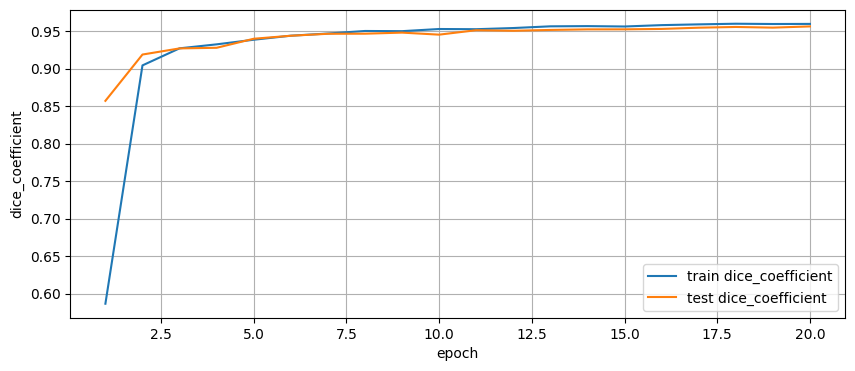


ResNet model with MSELoss

FLOPs: 36.29 MFLOPs
Number of Parameters: 0.06 M
Epoch: 1/20    Batch: 85/85   [ loss: 0.2367 - accuracy: 0.7940 - dice_coefficient: 0.6743 - jaccard_index: 0.5472 - sensitivity: 0.9314 - specificity: 0.7713 - f1_score_metric: 0.6716 - hausdorff_distance: 21.3784 - miou_metric: 0.5464 ] [ val_loss: 0.2210 - val_accuracy: 0.9672 - val_dice_coefficient: 0.8995 - val_jaccard_index: 0.8123 - val_sensitivity: 0.9066 - val_specificity: 0.9806 - val_f1_score_metric: 0.8985 - val_hausdorff_distance: 2.0456 - val_miou_metric: 0.8159 ]
Epoch: 2/20    Batch: 85/85   [ loss: 0.2191 - accuracy: 0.9707 - dice_coefficient: 0.9134 - jaccard_index: 0.8361 - sensitivity: 0.9289 - specificity: 0.9812 - f1_score_metric: 0.9123 - hausdorff_distance: 1.8794 - miou_metric: 0.8390 ] [ val_loss: 0.2193 - val_accuracy: 0.9734 - val_dice_coefficient: 0.9203 - val_jaccard_index: 0.8476 - val_sensitivity: 0.9347 - val_specificity: 0.9828 - val_f1_score_metric: 0.9187 - val_hausdorff_dis

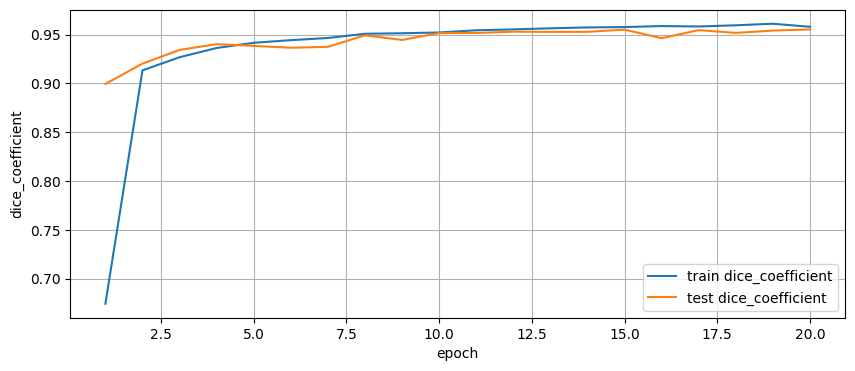


UNet model with BCELoss

FLOPs: 33.91 MFLOPs
Number of Parameters: 0.05 M
Epoch: 1/20    Batch: 85/85   [ loss: 0.6425 - accuracy: 0.8885 - dice_coefficient: 0.7889 - jaccard_index: 0.6819 - sensitivity: 0.9058 - specificity: 0.8880 - f1_score_metric: 0.7872 - hausdorff_distance: 13.6895 - miou_metric: 0.6832 ] [ val_loss: 0.6222 - val_accuracy: 0.9710 - val_dice_coefficient: 0.9106 - val_jaccard_index: 0.8300 - val_sensitivity: 0.9042 - val_specificity: 0.9854 - val_f1_score_metric: 0.9102 - val_hausdorff_distance: 1.8226 - val_miou_metric: 0.8353 ]
Epoch: 2/20    Batch: 85/85   [ loss: 0.6172 - accuracy: 0.9732 - dice_coefficient: 0.9207 - jaccard_index: 0.8481 - sensitivity: 0.9274 - specificity: 0.9844 - f1_score_metric: 0.9197 - hausdorff_distance: 1.6010 - miou_metric: 0.8515 ] [ val_loss: 0.6179 - val_accuracy: 0.9750 - val_dice_coefficient: 0.9231 - val_jaccard_index: 0.8508 - val_sensitivity: 0.9102 - val_specificity: 0.9890 - val_f1_score_metric: 0.9234 - val_hausdorff_dista

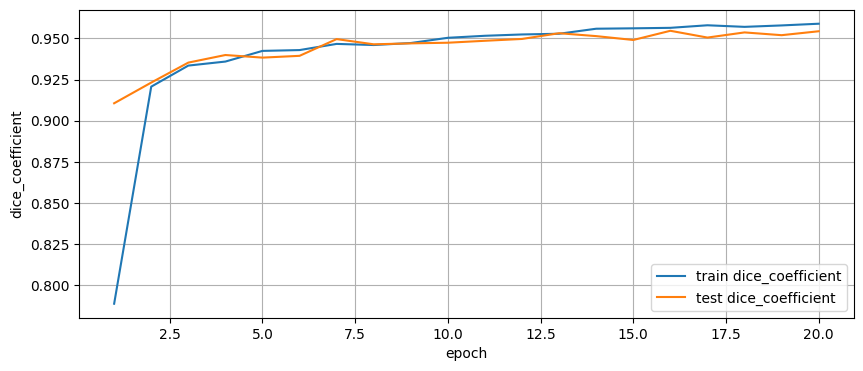


ResNet model with BCELoss

FLOPs: 36.29 MFLOPs
Number of Parameters: 0.06 M
Epoch: 1/20    Batch: 85/85   [ loss: 0.6490 - accuracy: 0.8877 - dice_coefficient: 0.7659 - jaccard_index: 0.6475 - sensitivity: 0.8785 - specificity: 0.8922 - f1_score_metric: 0.7644 - hausdorff_distance: 14.9135 - miou_metric: 0.6494 ] [ val_loss: 0.6247 - val_accuracy: 0.9663 - val_dice_coefficient: 0.8942 - val_jaccard_index: 0.8024 - val_sensitivity: 0.8830 - val_specificity: 0.9838 - val_f1_score_metric: 0.8945 - val_hausdorff_distance: 2.3163 - val_miou_metric: 0.8093 ]
Epoch: 2/20    Batch: 85/85   [ loss: 0.6185 - accuracy: 0.9698 - dice_coefficient: 0.9101 - jaccard_index: 0.8303 - sensitivity: 0.9208 - specificity: 0.9818 - f1_score_metric: 0.9093 - hausdorff_distance: 1.8946 - miou_metric: 0.8340 ] [ val_loss: 0.6183 - val_accuracy: 0.9736 - val_dice_coefficient: 0.9202 - val_jaccard_index: 0.8465 - val_sensitivity: 0.9247 - val_specificity: 0.9850 - val_f1_score_metric: 0.9196 - val_hausdorff_dis

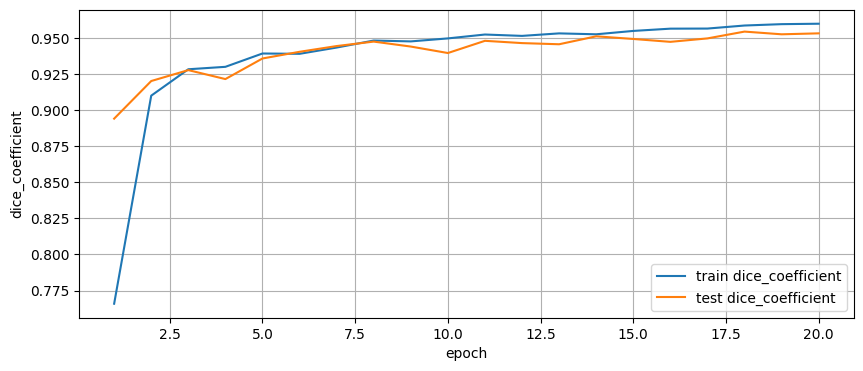


UNet model with FocalLoss

FLOPs: 33.91 MFLOPs
Number of Parameters: 0.05 M
Epoch: 1/20    Batch: 85/85   [ loss: 0.0599 - accuracy: 0.8466 - dice_coefficient: 0.7189 - jaccard_index: 0.5921 - sensitivity: 0.8663 - specificity: 0.8461 - f1_score_metric: 0.7179 - hausdorff_distance: 19.0345 - miou_metric: 0.5947 ] [ val_loss: 0.0576 - val_accuracy: 0.9663 - val_dice_coefficient: 0.8941 - val_jaccard_index: 0.8019 - val_sensitivity: 0.8788 - val_specificity: 0.9845 - val_f1_score_metric: 0.8949 - val_hausdorff_distance: 2.2269 - val_miou_metric: 0.8099 ]
Epoch: 2/20    Batch: 85/85   [ loss: 0.0573 - accuracy: 0.9696 - dice_coefficient: 0.9074 - jaccard_index: 0.8250 - sensitivity: 0.8966 - specificity: 0.9858 - f1_score_metric: 0.9077 - hausdorff_distance: 2.0585 - miou_metric: 0.8313 ] [ val_loss: 0.0572 - val_accuracy: 0.9748 - val_dice_coefficient: 0.9225 - val_jaccard_index: 0.8492 - val_sensitivity: 0.9057 - val_specificity: 0.9897 - val_f1_score_metric: 0.9233 - val_hausdorff_dis

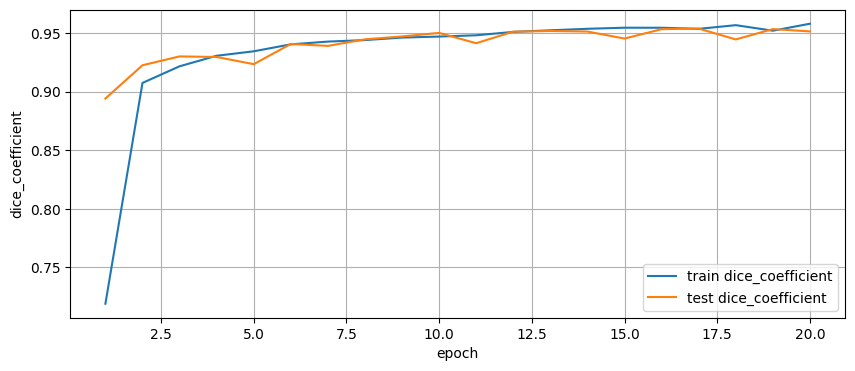


ResNet model with FocalLoss

FLOPs: 36.29 MFLOPs
Number of Parameters: 0.06 M
Epoch: 1/20    Batch: 85/85   [ loss: 0.0587 - accuracy: 0.9387 - dice_coefficient: 0.8277 - jaccard_index: 0.7243 - sensitivity: 0.8322 - specificity: 0.9611 - f1_score_metric: 0.8272 - hausdorff_distance: 6.1759 - miou_metric: 0.7283 ] [ val_loss: 0.0575 - val_accuracy: 0.9707 - val_dice_coefficient: 0.9104 - val_jaccard_index: 0.8303 - val_sensitivity: 0.9127 - val_specificity: 0.9836 - val_f1_score_metric: 0.9095 - val_hausdorff_distance: 1.7595 - val_miou_metric: 0.8341 ]
Epoch: 2/20    Batch: 85/85   [ loss: 0.0571 - accuracy: 0.9748 - dice_coefficient: 0.9257 - jaccard_index: 0.8568 - sensitivity: 0.9333 - specificity: 0.9851 - f1_score_metric: 0.9247 - hausdorff_distance: 1.3539 - miou_metric: 0.8601 ] [ val_loss: 0.0570 - val_accuracy: 0.9782 - val_dice_coefficient: 0.9358 - val_jaccard_index: 0.8741 - val_sensitivity: 0.9441 - val_specificity: 0.9869 - val_f1_score_metric: 0.9343 - val_hausdorff_di

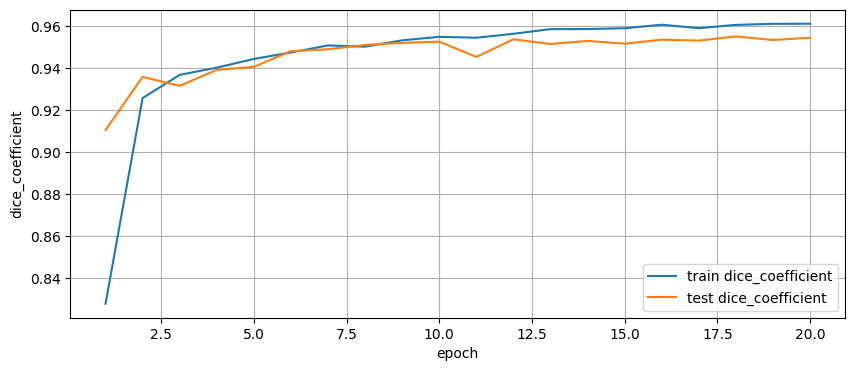


UNet model with DiceLoss

FLOPs: 33.91 MFLOPs
Number of Parameters: 0.05 M
Epoch: 1/20    Batch: 85/85   [ loss: 0.6380 - accuracy: 0.8723 - dice_coefficient: 0.7388 - jaccard_index: 0.6057 - sensitivity: 0.9526 - specificity: 0.8601 - f1_score_metric: 0.7345 - hausdorff_distance: 23.5910 - miou_metric: 0.6011 ] [ val_loss: 0.6214 - val_accuracy: 0.9458 - val_dice_coefficient: 0.8506 - val_jaccard_index: 0.7391 - val_sensitivity: 0.9817 - val_specificity: 0.9419 - val_f1_score_metric: 0.8452 - val_hausdorff_distance: 5.1054 - val_miou_metric: 0.7322 ]
Epoch: 2/20    Batch: 85/85   [ loss: 0.6094 - accuracy: 0.9599 - dice_coefficient: 0.8883 - jaccard_index: 0.7982 - sensitivity: 0.9807 - specificity: 0.9587 - f1_score_metric: 0.8836 - hausdorff_distance: 2.6712 - miou_metric: 0.7923 ] [ val_loss: 0.6135 - val_accuracy: 0.9640 - val_dice_coefficient: 0.8975 - val_jaccard_index: 0.8126 - val_sensitivity: 0.9834 - val_specificity: 0.9631 - val_f1_score_metric: 0.8924 - val_hausdorff_dist

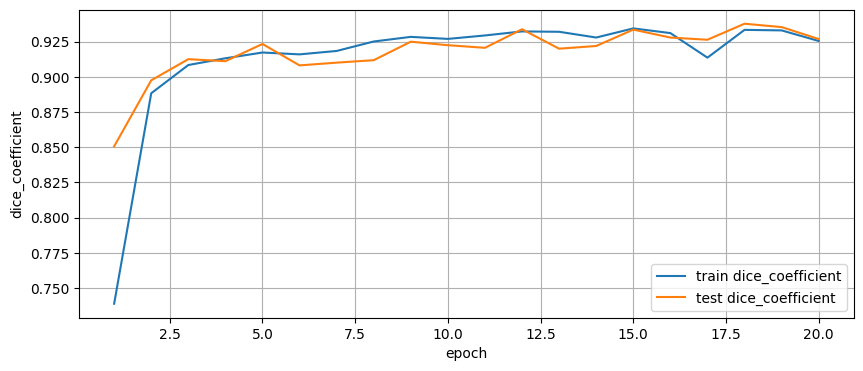


ResNet model with DiceLoss

FLOPs: 36.29 MFLOPs
Number of Parameters: 0.06 M
Epoch: 1/20    Batch: 85/85   [ loss: 0.6328 - accuracy: 0.8954 - dice_coefficient: 0.7683 - jaccard_index: 0.6443 - sensitivity: 0.9434 - specificity: 0.8893 - f1_score_metric: 0.7640 - hausdorff_distance: 12.5823 - miou_metric: 0.6394 ] [ val_loss: 0.6219 - val_accuracy: 0.9560 - val_dice_coefficient: 0.8763 - val_jaccard_index: 0.7788 - val_sensitivity: 0.9825 - val_specificity: 0.9538 - val_f1_score_metric: 0.8711 - val_hausdorff_distance: 2.7332 - val_miou_metric: 0.7719 ]
Epoch: 2/20    Batch: 85/85   [ loss: 0.6092 - accuracy: 0.9578 - dice_coefficient: 0.8832 - jaccard_index: 0.7902 - sensitivity: 0.9844 - specificity: 0.9555 - f1_score_metric: 0.8783 - hausdorff_distance: 2.5237 - miou_metric: 0.7837 ] [ val_loss: 0.6135 - val_accuracy: 0.9536 - val_dice_coefficient: 0.8709 - val_jaccard_index: 0.7707 - val_sensitivity: 0.9907 - val_specificity: 0.9494 - val_f1_score_metric: 0.8650 - val_hausdorff_di

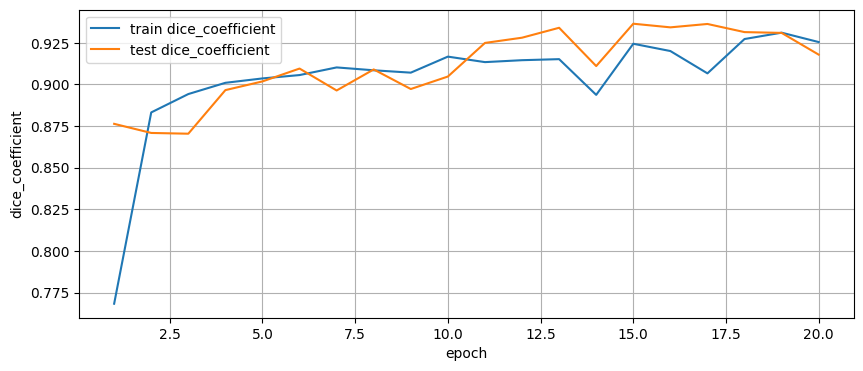


UNet model with DiceBCELoss

FLOPs: 33.91 MFLOPs
Number of Parameters: 0.05 M
Epoch: 1/20    Batch: 85/85   [ loss: 0.6514 - accuracy: 0.8595 - dice_coefficient: 0.7302 - jaccard_index: 0.6029 - sensitivity: 0.9002 - specificity: 0.8550 - f1_score_metric: 0.7280 - hausdorff_distance: 18.1853 - miou_metric: 0.6027 ] [ val_loss: 0.6260 - val_accuracy: 0.9538 - val_dice_coefficient: 0.8668 - val_jaccard_index: 0.7623 - val_sensitivity: 0.9494 - val_specificity: 0.9572 - val_f1_score_metric: 0.8636 - val_hausdorff_distance: 3.1447 - val_miou_metric: 0.7603 ]
Epoch: 2/20    Batch: 85/85   [ loss: 0.6189 - accuracy: 0.9677 - dice_coefficient: 0.9064 - jaccard_index: 0.8257 - sensitivity: 0.9482 - specificity: 0.9740 - f1_score_metric: 0.9040 - hausdorff_distance: 1.9996 - miou_metric: 0.8255 ] [ val_loss: 0.6185 - val_accuracy: 0.9700 - val_dice_coefficient: 0.9127 - val_jaccard_index: 0.8364 - val_sensitivity: 0.9631 - val_specificity: 0.9738 - val_f1_score_metric: 0.9092 - val_hausdorff_d

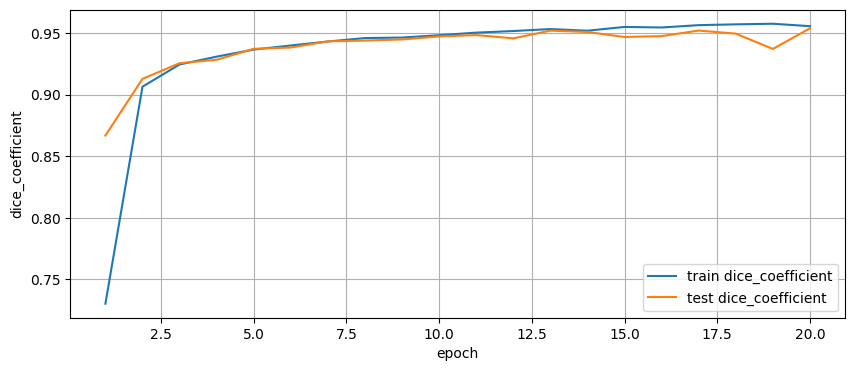


ResNet model with DiceBCELoss

FLOPs: 36.29 MFLOPs
Number of Parameters: 0.06 M
Epoch: 1/20    Batch: 85/85   [ loss: 0.6529 - accuracy: 0.9050 - dice_coefficient: 0.7728 - jaccard_index: 0.6552 - sensitivity: 0.8728 - specificity: 0.9135 - f1_score_metric: 0.7701 - hausdorff_distance: 11.7508 - miou_metric: 0.6536 ] [ val_loss: 0.6499 - val_accuracy: 0.9674 - val_dice_coefficient: 0.8952 - val_jaccard_index: 0.8035 - val_sensitivity: 0.8600 - val_specificity: 0.9891 - val_f1_score_metric: 0.8962 - val_hausdorff_distance: 2.1019 - val_miou_metric: 0.8121 ]
Epoch: 2/20    Batch: 85/85   [ loss: 0.6210 - accuracy: 0.9640 - dice_coefficient: 0.8969 - jaccard_index: 0.8109 - sensitivity: 0.9586 - specificity: 0.9677 - f1_score_metric: 0.8937 - hausdorff_distance: 2.1011 - miou_metric: 0.8083 ] [ val_loss: 0.6236 - val_accuracy: 0.9687 - val_dice_coefficient: 0.9092 - val_jaccard_index: 0.8304 - val_sensitivity: 0.9630 - val_specificity: 0.9723 - val_f1_score_metric: 0.9058 - val_hausdorff

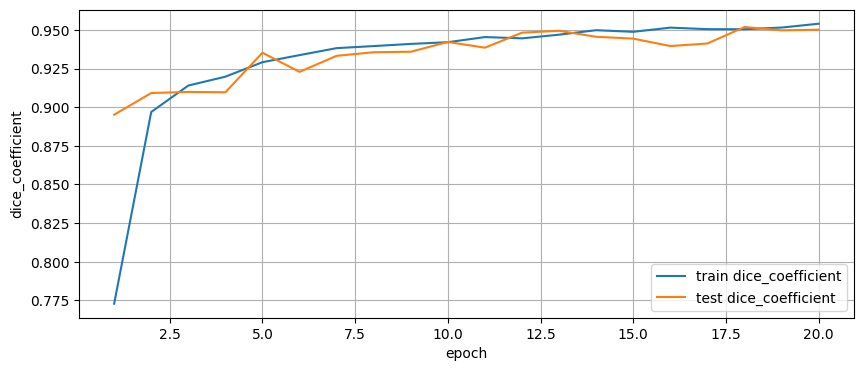


UNet model with HybridLoss

FLOPs: 33.91 MFLOPs
Number of Parameters: 0.05 M
Epoch: 1/20    Batch: 85/85   [ loss: 0.5800 - accuracy: 0.8857 - dice_coefficient: 0.7841 - jaccard_index: 0.6769 - sensitivity: 0.8684 - specificity: 0.8915 - f1_score_metric: 0.7829 - hausdorff_distance: 10.5006 - miou_metric: 0.6792 ] [ val_loss: 0.5593 - val_accuracy: 0.9708 - val_dice_coefficient: 0.9126 - val_jaccard_index: 0.8345 - val_sensitivity: 0.9316 - val_specificity: 0.9805 - val_f1_score_metric: 0.9110 - val_hausdorff_distance: 1.7513 - val_miou_metric: 0.8366 ]
Epoch: 2/20    Batch: 85/85   [ loss: 0.5544 - accuracy: 0.9734 - dice_coefficient: 0.9222 - jaccard_index: 0.8512 - sensitivity: 0.9373 - specificity: 0.9828 - f1_score_metric: 0.9207 - hausdorff_distance: 1.4305 - miou_metric: 0.8533 ] [ val_loss: 0.5545 - val_accuracy: 0.9758 - val_dice_coefficient: 0.9273 - val_jaccard_index: 0.8586 - val_sensitivity: 0.9296 - val_specificity: 0.9865 - val_f1_score_metric: 0.9266 - val_hausdorff_di

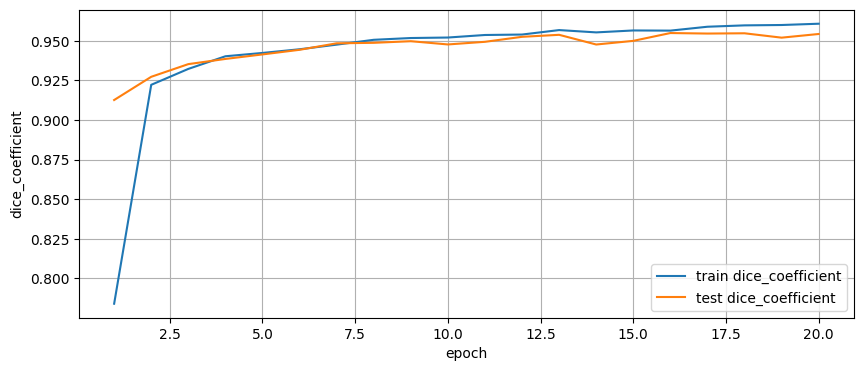


ResNet model with HybridLoss

FLOPs: 36.29 MFLOPs
Number of Parameters: 0.06 M
Epoch: 1/20    Batch: 85/85   [ loss: 0.6114 - accuracy: 0.8874 - dice_coefficient: 0.7330 - jaccard_index: 0.6098 - sensitivity: 0.8220 - specificity: 0.9021 - f1_score_metric: 0.7321 - hausdorff_distance: 15.8084 - miou_metric: 0.6126 ] [ val_loss: 0.5640 - val_accuracy: 0.9628 - val_dice_coefficient: 0.8760 - val_jaccard_index: 0.7717 - val_sensitivity: 0.8176 - val_specificity: 0.9914 - val_f1_score_metric: 0.8787 - val_hausdorff_distance: 2.5132 - val_miou_metric: 0.7839 ]
Epoch: 2/20    Batch: 85/85   [ loss: 0.5562 - accuracy: 0.9705 - dice_coefficient: 0.9112 - jaccard_index: 0.8316 - sensitivity: 0.9091 - specificity: 0.9846 - f1_score_metric: 0.9111 - hausdorff_distance: 1.8909 - miou_metric: 0.8370 ] [ val_loss: 0.5561 - val_accuracy: 0.9733 - val_dice_coefficient: 0.9191 - val_jaccard_index: 0.8449 - val_sensitivity: 0.9235 - val_specificity: 0.9848 - val_f1_score_metric: 0.9180 - val_hausdorff_

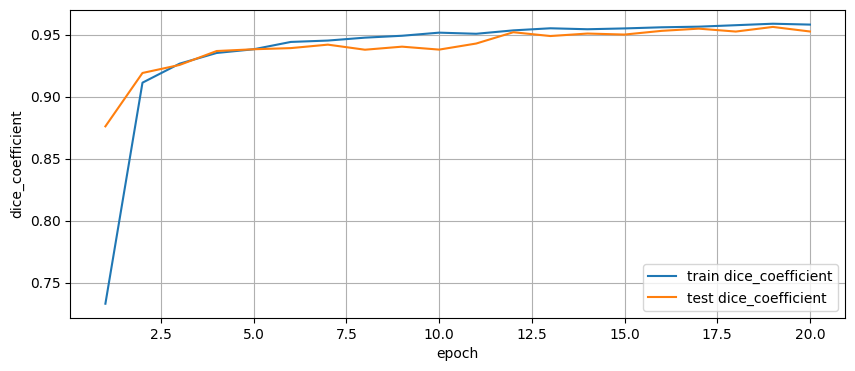


UNet model with BinaryLovaszLoss

FLOPs: 33.91 MFLOPs
Number of Parameters: 0.05 M
Epoch: 1/20    Batch: 85/85   [ loss: 1.3266 - accuracy: 0.9227 - dice_coefficient: 0.7753 - jaccard_index: 0.6535 - sensitivity: 0.7235 - specificity: 0.9623 - f1_score_metric: 0.7775 - hausdorff_distance: 8.6598 - miou_metric: 0.6631 ] [ val_loss: 1.3089 - val_accuracy: 0.9568 - val_dice_coefficient: 0.8461 - val_jaccard_index: 0.7250 - val_sensitivity: 0.7464 - val_specificity: 0.9968 - val_f1_score_metric: 0.8500 - val_hausdorff_distance: 3.2963 - val_miou_metric: 0.7394 ]
Epoch: 2/20    Batch: 85/85   [ loss: 1.2991 - accuracy: 0.9676 - dice_coefficient: 0.8957 - jaccard_index: 0.8038 - sensitivity: 0.8388 - specificity: 0.9941 - f1_score_metric: 0.8983 - hausdorff_distance: 2.2540 - miou_metric: 0.8158 ] [ val_loss: 1.3038 - val_accuracy: 0.9685 - val_dice_coefficient: 0.8959 - val_jaccard_index: 0.8030 - val_sensitivity: 0.8337 - val_specificity: 0.9951 - val_f1_score_metric: 0.8988 - val_hausdor

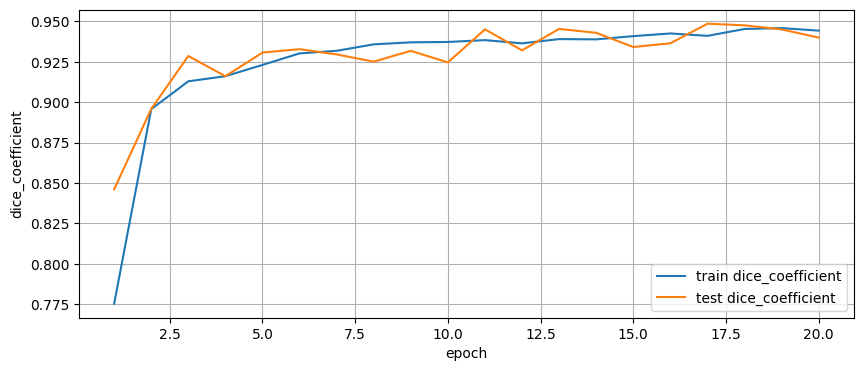


ResNet model with BinaryLovaszLoss

FLOPs: 36.29 MFLOPs
Number of Parameters: 0.06 M
Epoch: 1/20    Batch: 85/85   [ loss: 1.3631 - accuracy: 0.4899 - dice_coefficient: 0.4030 - jaccard_index: 0.2649 - sensitivity: 0.9209 - specificity: 0.4146 - f1_score_metric: 0.4003 - hausdorff_distance: 35.2971 - miou_metric: 0.2635 ] [ val_loss: 1.3489 - val_accuracy: 0.9134 - val_dice_coefficient: 0.7330 - val_jaccard_index: 0.5750 - val_sensitivity: 0.7675 - val_specificity: 0.9421 - val_f1_score_metric: 0.7330 - val_hausdorff_distance: 26.3868 - val_miou_metric: 0.5789 ]
Epoch: 2/20    Batch: 85/85   [ loss: 1.3433 - accuracy: 0.9251 - dice_coefficient: 0.7821 - jaccard_index: 0.6410 - sensitivity: 0.8077 - specificity: 0.9493 - f1_score_metric: 0.7826 - hausdorff_distance: 17.5064 - miou_metric: 0.6463 ] [ val_loss: 1.3450 - val_accuracy: 0.9205 - val_dice_coefficient: 0.7647 - val_jaccard_index: 0.6153 - val_sensitivity: 0.8321 - val_specificity: 0.9389 - val_f1_score_metric: 0.7646 - val_ha

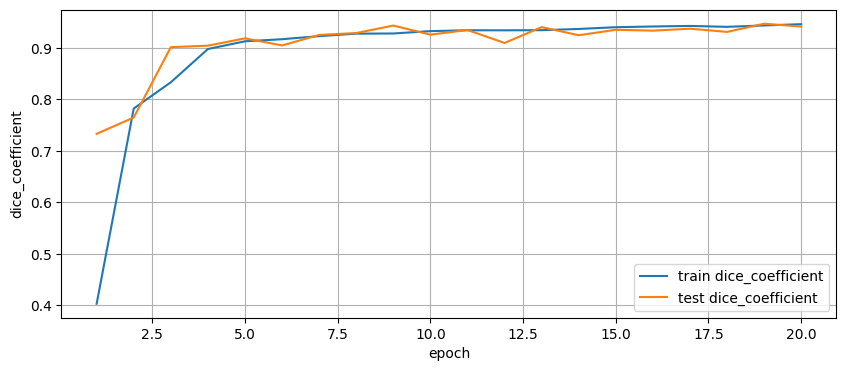


UNet model with LovaszBCELoss

FLOPs: 33.91 MFLOPs
Number of Parameters: 0.05 M
Epoch: 1/20    Batch: 85/85   [ loss: 1.9698 - accuracy: 0.9184 - dice_coefficient: 0.7903 - jaccard_index: 0.6736 - sensitivity: 0.7813 - specificity: 0.9466 - f1_score_metric: 0.7915 - hausdorff_distance: 7.8022 - miou_metric: 0.6813 ] [ val_loss: 1.9379 - val_accuracy: 0.9659 - val_dice_coefficient: 0.8865 - val_jaccard_index: 0.7880 - val_sensitivity: 0.8227 - val_specificity: 0.9941 - val_f1_score_metric: 0.8891 - val_hausdorff_distance: 2.2599 - val_miou_metric: 0.8004 ]
Epoch: 2/20    Batch: 85/85   [ loss: 1.9193 - accuracy: 0.9706 - dice_coefficient: 0.9086 - jaccard_index: 0.8258 - sensitivity: 0.8729 - specificity: 0.9915 - f1_score_metric: 0.9101 - hausdorff_distance: 1.8926 - miou_metric: 0.8354 ] [ val_loss: 1.9212 - val_accuracy: 0.9748 - val_dice_coefficient: 0.9210 - val_jaccard_index: 0.8461 - val_sensitivity: 0.8885 - val_specificity: 0.9927 - val_f1_score_metric: 0.9224 - val_hausdorff_

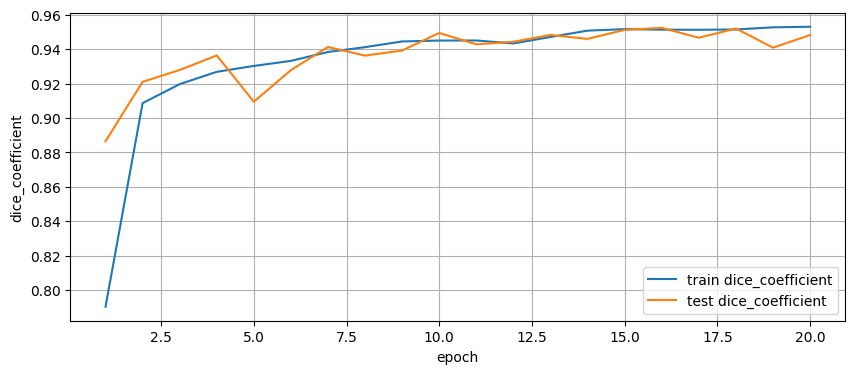


ResNet model with LovaszBCELoss

FLOPs: 36.29 MFLOPs
Number of Parameters: 0.06 M
Epoch: 1/20    Batch: 85/85   [ loss: 1.9638 - accuracy: 0.9223 - dice_coefficient: 0.8175 - jaccard_index: 0.7047 - sensitivity: 0.8531 - specificity: 0.9380 - f1_score_metric: 0.8177 - hausdorff_distance: 8.2975 - miou_metric: 0.7105 ] [ val_loss: 1.9367 - val_accuracy: 0.9627 - val_dice_coefficient: 0.8787 - val_jaccard_index: 0.7773 - val_sensitivity: 0.8416 - val_specificity: 0.9870 - val_f1_score_metric: 0.8795 - val_hausdorff_distance: 2.6085 - val_miou_metric: 0.7851 ]
Epoch: 2/20    Batch: 85/85   [ loss: 1.9203 - accuracy: 0.9693 - dice_coefficient: 0.9043 - jaccard_index: 0.8189 - sensitivity: 0.8718 - specificity: 0.9900 - f1_score_metric: 0.9056 - hausdorff_distance: 2.0428 - miou_metric: 0.8278 ] [ val_loss: 1.9301 - val_accuracy: 0.9697 - val_dice_coefficient: 0.9074 - val_jaccard_index: 0.8253 - val_sensitivity: 0.9132 - val_specificity: 0.9823 - val_f1_score_metric: 0.9063 - val_hausdorf

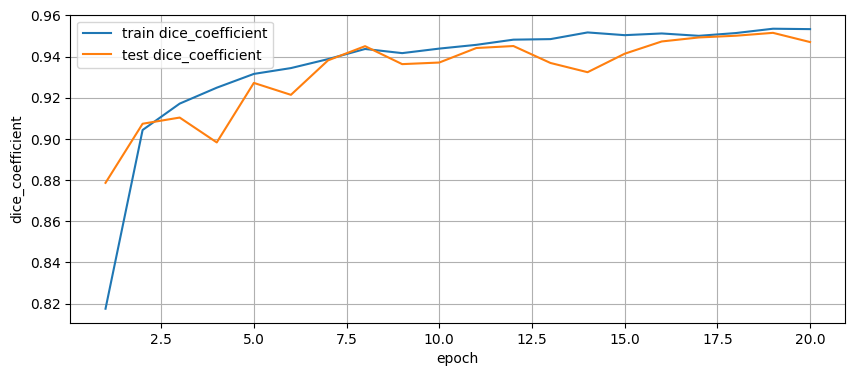

In [ ]:
models.clear()
base_models_names.clear()
base_accuracies.clear()

criterions = [
    nn.MSELoss(),
    nn.BCELoss(),
    FocalLoss(),
    DiceLoss(),
    DiceBCELoss(),
    HybridLoss(),
    BinaryLovaszLoss(),
    LovaszBCELoss(),
]

for criterion in criterions:
    print('=' * 100)
    print(f"UNet model with {criterion.__class__.__name__}")
    print()
    check_loss('UNet', criterion)
    print()

    print('=' * 100)
    print(f"ResNet model with {criterion.__class__.__name__}")
    print()
    check_loss('ResNet', criterion)
    print()

In [ ]:
result = list(zip(models, base_models_names, base_accuracies))
result = sorted(result, key=lambda x: x[2], reverse=True)

for item in result:
    print(f"{item[1]:<40} {item[2]:.4f}")

result = filter(lambda x: x[2] > 0.6, result)
models, base_models_names, base_accuracies = zip(*result)

UNet model with MSELoss                  0.9564
ResNet model with MSELoss                0.9553
ResNet model with FocalLoss              0.9544
UNet model with BCELoss                  0.9543
UNet model with HybridLoss               0.9543
UNet model with DiceBCELoss              0.9538
ResNet model with BCELoss                0.9533
ResNet model with HybridLoss             0.9525
UNet model with FocalLoss                0.9514
ResNet model with DiceBCELoss            0.9502
UNet model with LovaszBCELoss            0.9482
ResNet model with LovaszBCELoss          0.9471
ResNet model with BinaryLovaszLoss       0.9413
UNet model with BinaryLovaszLoss         0.9400
UNet model with DiceLoss                 0.9268
ResNet model with DiceLoss               0.9179


#Ensemble Models

In [ ]:
class SimpleAverageModel(nn.Module):
    trainable = False

    def __init__(self, models):
        super(SimpleAverageModel, self).__init__()
        self.models = models

    def forward(self, x):
        outputs = [(model(x) > 0.5).float() for model in self.models]
        average = torch.mean(torch.stack(outputs), dim=0)
        return average


class MajorityVotingModel(nn.Module):
    trainable = False

    def __init__(self, models):
        super(MajorityVotingModel, self).__init__()
        self.models = models

    def forward(self, x):
        outputs = [model(x) > 0.5 for model in self.models]
        mask_tensor = torch.stack(outputs, dim=0)

        # Majority voting
        ensemble_mask = mask_tensor.sum(dim=0) > len(models) // 2

        return ensemble_mask


class BitwiseAndModel(nn.Module):
    trainable = False

    def __init__(self, models):
        super(BitwiseAndModel, self).__init__()
        self.models = models

    def forward(self, x):
        outputs = [model(x) > 0.5 for model in self.models]
        stack = torch.stack(outputs, dim=0)

        result = stack[0]
        for i in range(1, len(stack)):
            result = torch.bitwise_and(result, stack[i])

        return result


class BitwiseOrModel(nn.Module):
    trainable = False

    def __init__(self, models):
        super(BitwiseOrModel, self).__init__()
        self.models = models

    def forward(self, x):
        outputs = [model(x) > 0.5 for model in self.models]
        stack = torch.stack(outputs, dim=0)

        result = stack[0]
        for i in range(1, len(stack)):
            result = torch.bitwise_or(result, stack[i])

        return result


class WeightedAverageModel(nn.Module):
    trainable = False

    def __init__(self, models, weights):
        super(WeightedAverageModel, self).__init__()
        self.models = models
        self.len_models = len(self.models)
        self.weights = F.softmax(torch.tensor(weights), dim=0)

    def forward(self, x):
        s = 0
        for i in range(self.len_models):
            s += self.weights[i] * (self.models[i](x) > 0.5)
        return s


class StackingMetaModel(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(StackingMetaModel, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=(1, 1)),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)

class StackingModel(nn.Module):
    trainable = True

    def __init__(self, models, meta_model):
        super(StackingModel, self).__init__()
        self.models = models
        self.len_models = len(self.models)
        self.output = meta_model

    def forward(self, x):
        outputs = [model(x) for model in self.models]
        stack = torch.cat(outputs, dim=1)
        output = self.output(stack)
        return F.sigmoid(output)


#Checking different ensemble models

In [ ]:
ensemble_models_names = []
ensemble_accuracies = []

def check_ensemble_model(ensemble_model, criterion):
    if ensemble_model.trainable:
        model_fit = ModelFit(ensemble_model, criterion)
        history = model_fit.fit(train_loader=train_loader, test_loader=test_loader, epochs=epochs)
        plot_metric(history, 'dice_coefficient')
        model_accuracy = history['val_dice_coefficient'][-1]

    else:
        for metric in [accuracy, dice_coefficient, jaccard_index, sensitivity, specificity, f1_score_metric, hausdorff_distance, miou_metric,]:
            model_accuracy = evaluate(ensemble_model, test_loader, metric=metric)
            print(f"{metric.__name__ }: {model_accuracy:.4f}")
        model_accuracy = evaluate(ensemble_model, test_loader)

    name = f"{ensemble_model.__class__.__name__}"
    ensemble_models_names.append(name)
    ensemble_accuracies.append(model_accuracy)

    for i in range(0):
        print()
        check(ensemble_model, i)

Ensemble model: SimpleAverageModel

accuracy: 0.9863
dice_coefficient: 0.9619
jaccard_index: 0.9200
sensitivity: 0.9592
specificity: 0.9937
f1_score_metric: 0.9612
hausdorff_distance: 1.0000
miou_metric: 0.9253

Ensemble model: MajorityVotingModel

accuracy: 0.9863
dice_coefficient: 0.9619
jaccard_index: 0.9200
sensitivity: 0.9592
specificity: 0.9937
f1_score_metric: 0.9612
hausdorff_distance: 1.0000
miou_metric: 0.9253

Ensemble model: BitwiseAndModel

accuracy: 0.9757
dice_coefficient: 0.9215
jaccard_index: 0.8435
sensitivity: 0.8577
specificity: 0.9993
f1_score_metric: 0.9269
hausdorff_distance: 1.4911
miou_metric: 0.8639

Ensemble model: BitwiseOrModel

accuracy: 0.9623
dice_coefficient: 0.8943
jaccard_index: 0.8085
sensitivity: 0.9976
specificity: 0.9585
f1_score_metric: 0.8878
hausdorff_distance: 2.0675
miou_metric: 0.7984

Ensemble model: WeightedAverageModel

accuracy: 0.9863
dice_coefficient: 0.9618
jaccard_index: 0.9200
sensitivity: 0.9594
specificity: 0.9937
f1_score_metric:

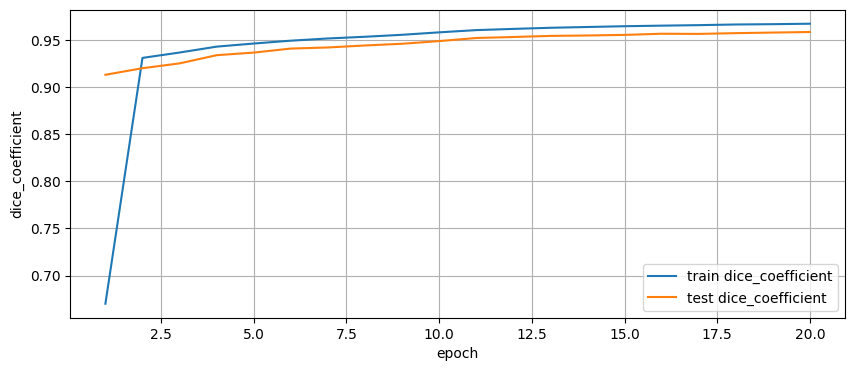

In [ ]:
ensemble_models_names.clear()
ensemble_accuracies.clear()

for model in models:
    model.eval()

criterion = nn.BCELoss()

ensemble_models = [
    SimpleAverageModel(models),
    MajorityVotingModel(models),
    BitwiseAndModel(models),
    BitwiseOrModel(models),
    WeightedAverageModel(models, weights=base_accuracies),
    StackingModel(models, meta_model=StackingMetaModel(in_ch=len(models), out_ch=1)),
]

for ensemble_model in ensemble_models:
    print('=' * 100)
    print(f"Ensemble model: {ensemble_model.__class__.__name__}")
    print()
    check_ensemble_model(ensemble_model, criterion)
    print()


In [ ]:
result = list(zip(ensemble_models_names, ensemble_accuracies))
result = sorted(result, key=lambda x: x[1], reverse=True)

for item in result:
    print(f"{item[0]:<40} {item[1]:.4f}")

SimpleAverageModel                       0.9619
MajorityVotingModel                      0.9619
WeightedAverageModel                     0.9618
StackingModel                            0.9585
BitwiseAndModel                          0.9215
BitwiseOrModel                           0.8943
